In [12]:
import numpy as np
import scipy.ndimage as sn
import scipy.signal as ss
import matplotlib.pyplot as plt
import skimage
from skimage.io import imsave
from skimage import morphology as mp
from skimage import transform
import math
from skimage.color import rgb2hsv, hsv2rgb
from skimage.util import random_noise as rn
from PIL.Image import open as imread
from PIL import ImageOps as Iops
import time
import matplotlib
from random import random

In [2]:
def showG(im, boundaries = False, cmap='gray'):
    if boundaries:
        plt.imshow(im, cmap=cmap, vmin=0, vmax=255)
    else:    
        plt.imshow(im, cmap=cmap)
        plt.colorbar()
    
    return plt.show()
    
def loadIm(im, show = True):
    g = Iops.grayscale(imread(im))
    A = np.array(g)
    if show: showG(A)
    return A


In [ ]:
# 1.1
def hough_transform(im, sigma = 3, threshold = 0.99):
  im = skimage.feature.canny(im, sigma, 0.4, 0.9)
  w, h = im.shape
  diagonal = int(np.ceil(np.sqrt(w**2 + h**2))) 
  
  thetas = np.deg2rad(np.arange(-90.0, 90.0))
  rhos = np.linspace(-diagonal, diagonal, diagonal * 2)

  cos = np.cos(thetas)
  sin = np.sin(thetas)

  acc = np.zeros((2 * diagonal, len(thetas)))
  ys, xs = np.nonzero(im)

  # Voteing
  for x, y in zip(xs, ys):
    for ti, s, c in zip(range(len(thetas)), sin, cos):
      acc[round((x * c + y * s) + diagonal) , ti] += 1


  max_points = np.argwhere(acc/np.max(acc) > threshold)
  
  rho = rhos[max_points // acc.shape[1]]
  theta = thetas[max_points % acc.shape[1]]

  return acc, thetas, rhos

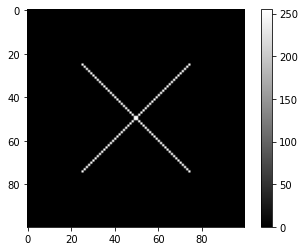

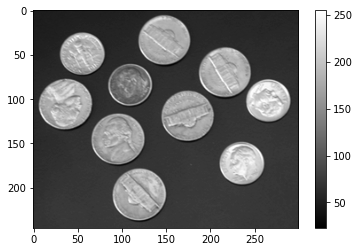

In [ ]:
A1 = loadIm('cross.png')

A2 = loadIm('coins.png')

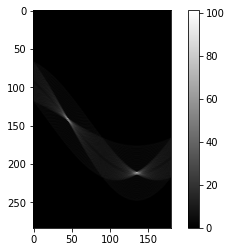

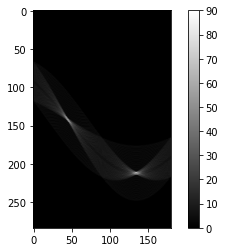

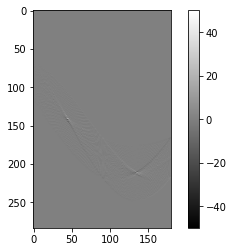

In [ ]:
# 1.2
# Skimage version https://github.com/scikit-image/scikit-image/blob/main/skimage/transform/_hough_transform.pyx
acc, theta, rho = hough_transform(A1, 1)
showG(acc)

im = skimage.feature.canny(A1, 1, 0.4, 1)
h, theta_skimage, rho_skimage = skimage.transform.hough_line(im)
showG(h)

showG(acc-h)

In [ ]:
def get_speckles(mod, radius):
    mod = mod.copy()
    mod = mod/np.max(mod)
    x_max = mod.shape[1]
    y_max = mod.shape[0]
    specs = []
    xs, ys = np.where(mod >= 0.9)
    max_idx = zip(ys,xs)

    for x,y in max_idx:
        print(x,y)
        max_val = mod[y,x]
        if max_val == -1: continue
        for i in range(y-radius,y+radius):
            for j in range(x-radius,x+radius):
                if(mod[i,j] > max_val):
                    max_val = mod[i,j]
                    y = i
                    x = j
    
        specs.append([y,x])      
        
        mod[max(0,y-radius):min(y+radius, y_max),max(0,x-radius):min(x+radius, x_max)] = -1
            
    return np.array(specs)

max_points = get_speckles(acc,10)

45 141
45 143
135 211
135 213


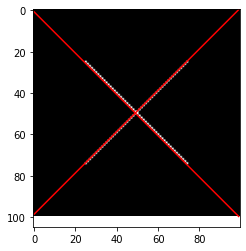

In [ ]:
rh = rho[max_points[:,0] ]
th = theta[max_points[:,1]]


plt.imshow(A1,cmap='gray')
for r, t in zip(rh, th): 
    X = np.arange(0,A1.shape[1])
    Y = -np.cos(t)/np.sin(t)*X+r/np.sin(t)
    plt.plot(X,Y,c='red')

plt.show()

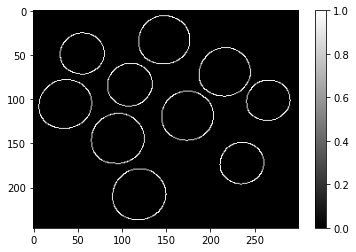

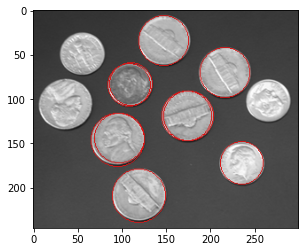

In [ ]:
# 1.3
image = A2

edges = skimage.feature.canny(image, sigma=3, low_threshold=20, high_threshold=80)

showG(edges)

# Detect two radii
hough_radii = np.arange(20, 35, 2)
hough_res = skimage.transform.hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_res, hough_radii, total_num_peaks=10)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = skimage.color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = skimage.draw.circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

In [3]:
test = np.load('test.npz')
x_test = test['x_test']
y_test = test['y_test']

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, InputLayer
from tensorflow.keras.optimizers import Adam
import keras

In [5]:
# batch_size to train
batch_size = 20 * 256
# number of output classes
nb_classes = 135
# number of epochs to train
nb_epoch = 400

# number of convolutional filters to use
nb_filters = 20
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 5

model = Sequential([
    InputLayer(input_shape=(29, 29, 1)),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    Dropout(0.5),
    Conv2D(filters=nb_filters, kernel_size=nb_conv, activation='relu'),
    MaxPool2D(pool_size=(nb_pool, nb_pool)),
    Dropout(0.25),
    Flatten(),
    Dense(units=4000, activation='relu'),
    Dense(units=nb_classes, activation='softmax'),
])
    
optimizer = Adam(lr=1e-4, epsilon=1e-08)

model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.load_weights('keras.h5') 

In [ ]:
# 2.2
model.evaluate(x_test.reshape(-1,29,29,1), y_test)

1317/1317 [==============================] - 13s 9ms/step - loss: 0.1172 - accuracy: 0.9567


[0.11660551279783249, 0.9576659202575684]

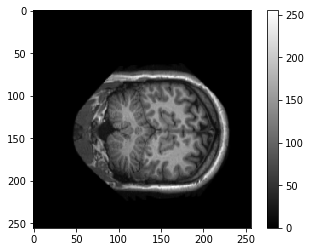

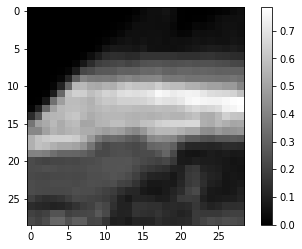

In [6]:
im = loadIm('image/1003_3_image.png')

def get_patch(im, center = [0,0]):
    w, h = im.shape
    x, y = center
    patch = im[max(0,x-14):min(w,x+15),max(0,y-14):min(h, y+15)]
    patch = patch/255
    w, h = patch.shape

    if w != 29 or h != 29:
        v = np.zeros((29,29))
        v[14-w//2:14+math.ceil(w/2), 14-h//2:14+math.ceil(h/2)] = patch
        return v

    return patch

showG(get_patch(im, [80,100]))

In [7]:
def extract_patches(im):
    w, h = im.shape
    patches = []
    for x in range(w):
        for y in range(h):
            patches.append(get_patch(im, [x,y]))
    return np.array(patches).reshape(-1,29,29,1)

In [13]:
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=135)

In [14]:
train = np.load('train.npz')
x_train = (train['x_train'])
y_train = (train['y_train'])

In [9]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train.reshape((len(x_train), -1)), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

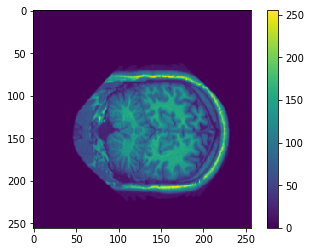

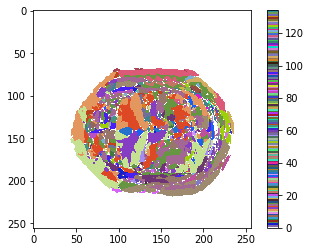

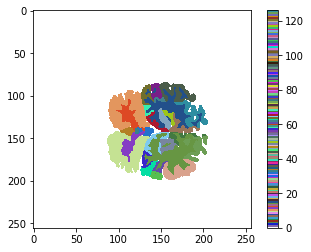

0.7035675048828125


In [47]:
#def ml_on_im(data, model, batch_size = 10):
data = '1003'
model = neigh

im = loadIm('image/{}_3_image.png'.format(data), False)
truth = loadIm('seg/{}_3_seg.png'.format(data), False)

set_ = extract_patches(im)
set_ = set_.reshape(256*256,1,29*29)


res = []
c = 0
set_len = set_.shape[0]


for i in range(set_len):
    print(set_len-c, end='\r')
    c += 1
    res.append(model.predict(set_[i]))

segments = np.argmax(np.array(res), axis=2).reshape(im.shape)

showG(im, cmap='viridis')
showG(segments, cmap=new_map)
showG(truth, cmap=new_map)

dice = 2*np.sum(truth==segments)/(2*len(np.ravel(truth)))

print(dice)

In [22]:
segments = np.argmax(np.array(res), axis=2).reshape(im.shape)

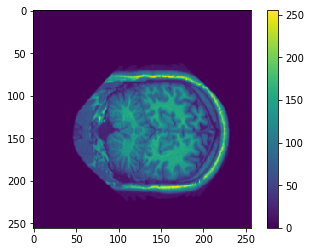

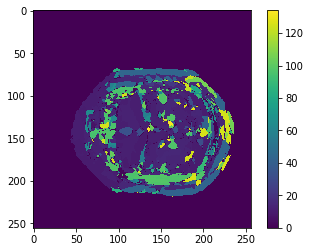

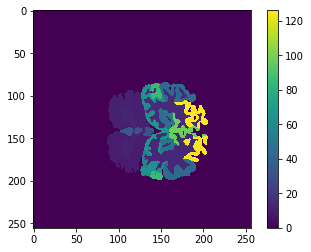

0.7035675048828125


In [23]:
showG(im, cmap='viridis')
showG(segments, cmap='viridis')
showG(truth, cmap='viridis')

dice = 2*np.sum(truth==segments)/(2*len(np.ravel(truth)))

#return dice
print(dice)

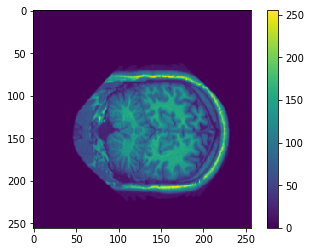

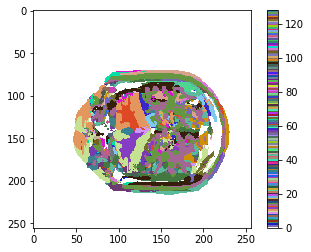

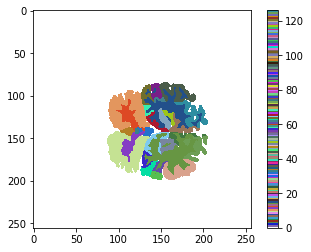

0.7633819580078125


In [45]:
data = '1003'
model = model

im = loadIm('image/{}_3_image.png'.format(data), False)
truth = loadIm('seg/{}_3_seg.png'.format(data), False)

set_ = extract_patches(im)
res = model.predict(set_, use_multiprocessing=True)

segments = np.argmax(res, axis=1).reshape(im.shape)

showG(im, cmap='viridis')
showG(segments, cmap=new_map)
showG(truth, cmap=new_map)

dice = 2*np.sum(truth==segments)/(2*len(np.ravel(truth)))

print(dice)

In [30]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x_train.reshape((len(x_train), -1)), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

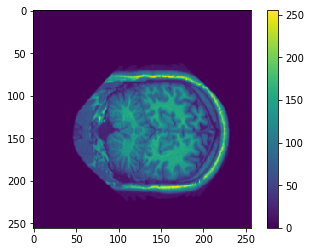

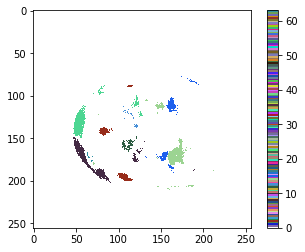

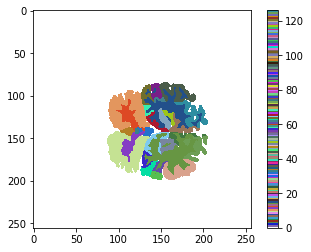

0.8369903564453125


In [46]:
data = '1003'
model = forest

im = loadIm('image/{}_3_image.png'.format(data), False)
truth = loadIm('seg/{}_3_seg.png'.format(data), False)

set_ = extract_patches(im)
set_ = set_.reshape(256*256,1,29*29)


res = []
c = 0
set_len = set_.shape[0]


for i in range(set_len):
    print(set_len-c, end='\r')
    c += 1
    res.append(model.predict(set_[i]))

segments = np.argmax(np.array(res), axis=2).reshape(im.shape)

showG(im, cmap='viridis')
showG(segments, cmap=new_map)
showG(truth, cmap=new_map)

dice = 2*np.sum(truth==segments)/(2*len(np.ravel(truth)))

#return dice
print(dice)

In [27]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=135)
kmeans.fit(x_train.reshape((len(x_train), -1)), y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=135, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

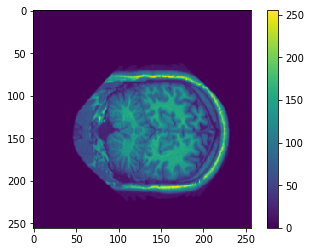

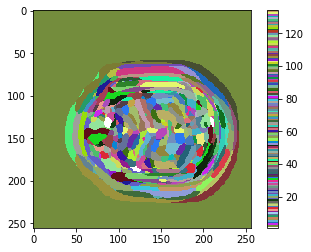

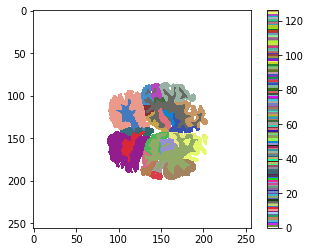

0.000885009765625


In [29]:
data = '1003'
model = kmeans

im = loadIm('image/{}_3_image.png'.format(data), False)
truth = loadIm('seg/{}_3_seg.png'.format(data), False)

set_ = extract_patches(im)
set_ = set_.reshape(256*256,1,29*29)


res = []
c = 0
set_len = set_.shape[0]


for i in range(set_len):
    print(set_len-c, end='\r')
    c += 1
    res.append(model.predict(set_[i]))

segments = np.array(res).reshape(im.shape)

showG(im, cmap='viridis')
showG(segments, cmap=new_map)
showG(truth, cmap=new_map)

dice = 2*np.sum(truth==segments)/(2*len(np.ravel(truth)))

print(dice)

In [22]:
print(res[150])

[1]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ac50c0c6-e99a-42c4-969f-78e7f2ff474d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>